# <font color='blue'>Projeto  2 - Análise de sentimentos</font>

## <font color='blue'>Descrição</font>

Análise de sentimentos é um campo do processamento de linguagem natural que busca a partir de textos/reviews de cliente e usuários determinar quais sentimentos os clientes expressaram. Essa técnica possibilita empresas melhorarem seus serviços, produtos, processos e políticas de atendimento ao público.

Nesse projeto foi utilizado a base de dados da OLIST, disponível livremente no kaggle. A principal ferramenta utilizada foi a biblioteca Transformers da Hugging Face, o estado da arte em soluções NLP. Essa biblioteca disponibiliza modelos BERT pré-treinados para tokenize e modelos de deep learning construídos em TensorFlow ou PyTorch. Isso possibilita maior poder e facilidade na tarefa de análise de sentimentos.

BERT de Bidirectional Encoder Representations from Transformers é um algoritmo de deep learning criado pelo Google para processamento de linguagem natural. A principal diferença desse algoritmo para os anteriores é que ele tem aprendizado bidirecional e não sequencial, dessa forma o algoritmo tem um entendimento maior sobre o contexto das palavras e expressões, já que ele sempre olha os dois lados e não segue uma sequência. 

## <font color='blue'>Dados</font>
<https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce>

## <font color='blue'>1 - Importando bibliotecas</font>

In [3]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score
import warnings

warnings.simplefilter('ignore')

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Froud GPU at: {device_name}')

Froud GPU at: /device:GPU:0


In [5]:
df = pd.read_csv('/content/drive/MyDrive/nlp_olist/olist_order_reviews_dataset.csv')

In [6]:
df.shape

(99224, 7)

In [7]:
df.dtypes

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [8]:
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## <font color='blue'>2 - Preparando novo Data Frame</font> 

In [9]:
# Separando X e y
data = df[['review_score', 'review_comment_message']]

In [10]:
data.dropna(axis=0, inplace=True)

In [11]:
data.shape

(40977, 2)

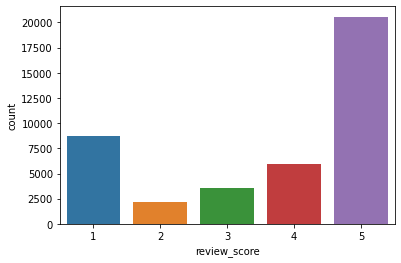

In [12]:
sns.countplot(data['review_score'])

### <font color='blue'> Definindo labels</font> 

In [13]:
def sentiment(x):    
    if x <= 3:
        return 0
    else:
        return 1

In [14]:
data['sentiment'] = data['review_score'].apply(sentiment)

In [15]:
data.drop('review_score', axis=1, inplace=True)

In [16]:
data.head()

,review_comment_message,sentiment
3,Recebi bem antes do prazo estipulado.,1
4,Parabéns lojas lannister adorei comprar pela I...,1
9,aparelho eficiente. no site a marca do aparelh...,1
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,"Vendedor confiável, produto ok e entrega antes...",1


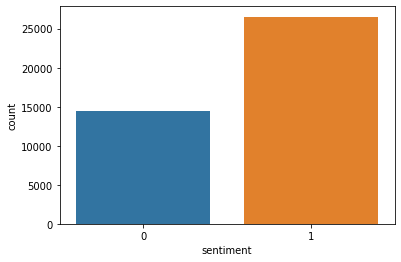

In [17]:
sns.countplot(data['sentiment'])

## <font color='blue'>3 - Limpando reviews com RegEx</font>

In [18]:
def clean(text):
    
    # remove links
    text = re.sub(r'http\S+',' ', text)
    
    # remove email
    text = re.sub(r'\S*@\S*\s?',' ', text)
    
    # substitui & por e
    text = re.sub (r"&","e",text)
    
    # deixa apenas letras e !
    text = re.sub("[^a-zA-Z!]", ' ', text)
    
    # tirar os espaços a mais
    text = re.sub(r"\s+"," ",text)
    
    # Colocando o texto em lower case
    return text.lower()

In [19]:
data['review_comment_message'] = data['review_comment_message'].apply(clean)

## <font color='blue'>4 - Visualizando principais palavras nas reviews</font>

In [20]:
text = " ".join(text for text in data['review_comment_message'])
text0 = " ".join(text for text in data[data['sentiment']==0]['review_comment_message'])
text1 = " ".join(text for text in data[data['sentiment']==1]['review_comment_message'])

In [22]:
stopwords = set(stopwords.words('portuguese'))

In [23]:
word_cloud = WordCloud(stopwords=stopwords, collocations = False, background_color='black',
                        width = 2048, height = 1080).generate(text)
word_cloud0 = WordCloud(stopwords=stopwords, collocations = False,background_color='black',
                        width = 2048, height = 1080).generate(text0)
word_cloud1 = WordCloud(stopwords=stopwords, collocations = False, background_color='black',
                        width = 2048, height = 1080).generate(text1)

### <font color='blue'>4.1 - Principais palavras nas reviews</font>

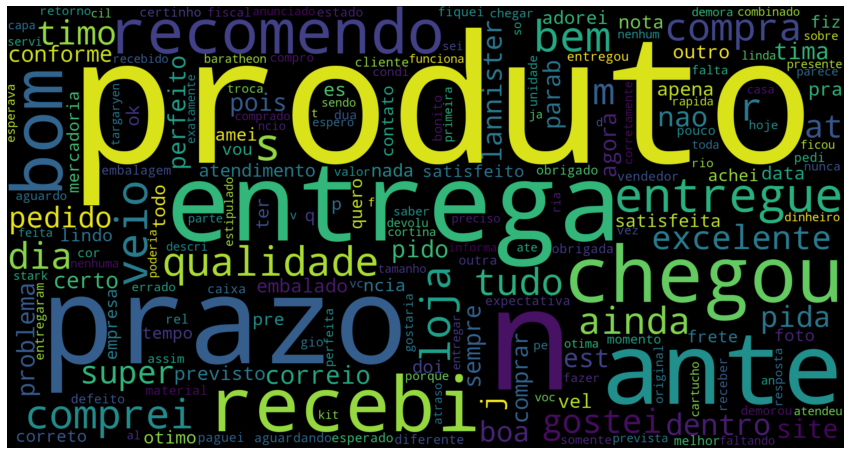

In [24]:
plt.figure(figsize=(15, 9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### <font color='blue'>4.2 - Principais palavras nas reviews negativas</font> 

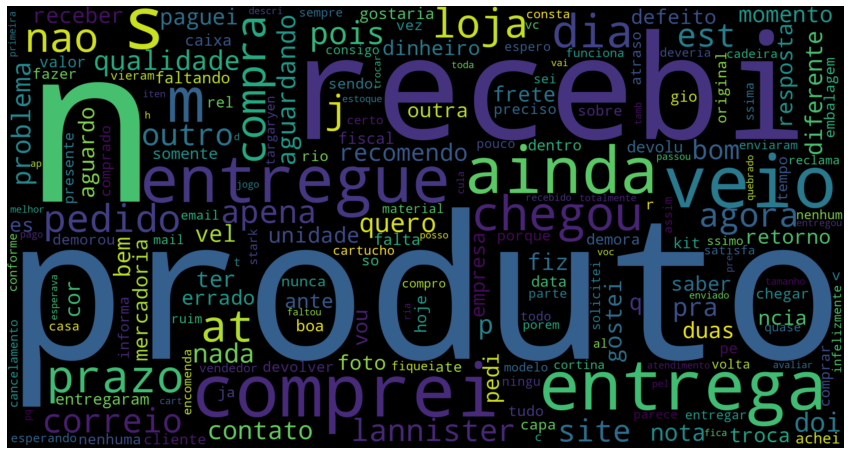

In [25]:
plt.figure(figsize=(15, 9))
plt.imshow(word_cloud0, interpolation='bilinear')
plt.axis("off")
plt.show()

### <font color='blue'>4.3 - Principais palavras nas reviews positivas</font> 

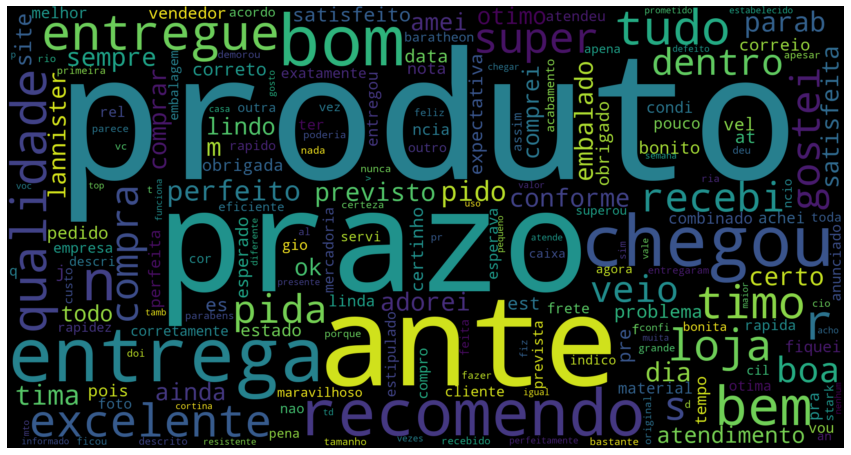

In [26]:
plt.figure(figsize=(15, 9))
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### <font color='blue'>4.4 - Insights</font> 

- Como esperado para um varejista online, palavras que remetem a tempo de entrega são as que mais aparecem
- Seguidas por termos que expressam a condição do produto

## <font color='blue'>5 - Encoder e preparação de dados</font>

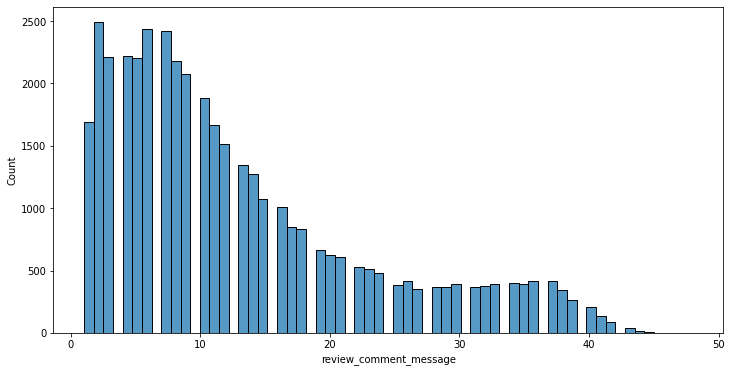

In [27]:
reviews_len = data.review_comment_message.apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(12, 6))
sns.histplot(reviews_len)

In [28]:
print(reviews_len.max())

48


In [29]:
# Dividindo dados em treino e validação
train_text, val_text, train_labels, val_labels = train_test_split(data['review_comment_message'], 
                                                                  data['sentiment'],
                                                                  test_size=0,
                                                                  random_state=42)

### <font color='blue'>5.1 - Modelo BERT para tokenização</font>

In [30]:
model = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(model, add_special_tokens=True, max_length=85, pad_to_max_length=True) 

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [31]:
# Teste

text = 'O produto é muito bom e a entrega foi rápida'

tokens = tokenizer.encode_plus(text)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {text}\n')
print(f'Tokens: {tokens}\n')
print(f'Token IDs: {token_ids}')

Sentence: O produto é muito bom e a entrega foi rápida

Tokens: {'input_ids': [101, 231, 3576, 253, 785, 4062, 122, 123, 9358, 262, 6740, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Token IDs: [100, 100, 100]


### <font color='blue'>5.2 - Tokenização dos reviews</font>

In [32]:
def encoder(text):
  tokens = tokenizer.batch_encode_plus(text ,max_length = 65, pad_to_max_length = True,return_attention_mask = True, truncation = True)
  return tokens

In [33]:
train = encoder(train_text.tolist())
val = encoder(val_text.tolist())

train_inputIds = np.asarray(train['input_ids'])
train_mask = np.array(train['attention_mask'])
train_labels = np.array(train_labels)

val_inputIds = np.asarray(val['input_ids'])
val_mask = np.array(val['attention_mask'])
val_labels = np.array(val_labels)

In [34]:
data_train = [train_inputIds, train_mask]
data_val = [val_inputIds, val_mask]

## <font color='blue'>6 - Modelo BERT de deep learning</font> 

In [35]:
with tf.device('/device:GPU:0'):
    bert_model = TFBertForSequenceClassification.from_pretrained(model)
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/529M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,924,674
Trainable params: 108,924,674
Non-trainable params: 0
_________________________________________________________________


In [37]:
print('BERT Model Olist')
history = bert_model.fit(data_train,train_labels,batch_size=32,epochs=3,validation_data=(data_val, val_labels))

BERT Model Olist
Epoch 1/3
1025/1025 [==============================] - 494s 462ms/step - loss: 0.2568 - accuracy: 0.9053 - val_loss: 0.2558 - val_accuracy: 0.9078
Epoch 2/3
1025/1025 [==============================] - 469s 457ms/step - loss: 0.2071 - accuracy: 0.9269 - val_loss: 0.2541 - val_accuracy: 0.9082
Epoch 3/3
1025/1025 [==============================] - 468s 457ms/step - loss: 0.1719 - accuracy: 0.9422 - val_loss: 0.2764 - val_accuracy: 0.9095


## <font color='blue'>7 - Avaliação e deploy</font> 

In [38]:
predict = bert_model.predict(data_val)
pred = np.argmax(predict.logits, axis=1)

257/257 [==============================] - 41s 147ms/step


In [39]:
print(classification_report(val_labels,pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2881
           1       0.93      0.93      0.93      5315

    accuracy                           0.91      8196
   macro avg       0.90      0.90      0.90      8196
weighted avg       0.91      0.91      0.91      8196



In [40]:
print(roc_auc_score(val_labels,pred))

0.8995192494505312


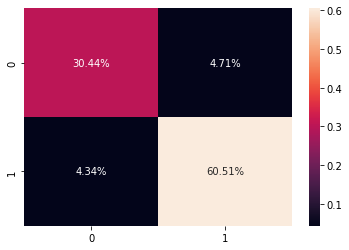

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_labels,pred)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%')

In [42]:
def sentiment(text):
  text = pd.DataFrame([text], columns=['text'])
  text_clean = text.text.apply(clean)
  text_encoder = encoder(text_clean.tolist())
  text_inputIds = np.asarray(text_encoder['input_ids'])
  text_mask = np.array(text_encoder['attention_mask'])
  data_val = [text_inputIds, text_mask]
  predict = bert_model.predict(data_val)
  pred = np.argmax(predict.logits, axis=1)
  if pred[0] == 0:
    print('Sentimento Negativo')
  else:
    print('Sentimento Positivo')

In [43]:
sentiment('produto ruim e mal acabado')

1/1 [==============================] - 0s 45ms/step
Sentimento Negativo


In [44]:
sentiment('Entrega Rápida e produto bom')

1/1 [==============================] - 0s 38ms/step
Sentimento Positivo


In [45]:
bert_model.save_pretrained('/content/drive/MyDrive/nlp_olist/bert_model')
tokenizer.save_pretrained('/content/drive/MyDrive/nlp_olist/tokenizer')

('/content/drive/MyDrive/nlp_olist/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/nlp_olist/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/nlp_olist/tokenizer/vocab.txt',
 '/content/drive/MyDrive/nlp_olist/tokenizer/added_tokens.json')

# <font color='blue'>Obrigado!!!</font> 